In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
awsaf49_brats20_dataset_training_validation_path = kagglehub.dataset_download('awsaf49/brats20-dataset-training-validation')

print('Data source import complete.')


Data source import complete.


In [2]:
pip install nibabel matplotlib scikit-image opencv-python tensorflow


In [3]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

In [4]:
BASE_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData"

IMG_SIZE = 128  # Resize to speed up training

In [5]:
def load_nifti_image(filepath):
    img = nib.load(filepath)
    img_data = img.get_fdata()
    return img_data

In [6]:
def normalize_img(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

In [7]:
def preprocess_single_case(img_path, mask_path):
    img_data = normalize_img(load_nifti_image(img_path))
    mask_data = load_nifti_image(mask_path)

    # Choose the middle slice for simplicity (can use 3D later)
    mid_slice = img_data.shape[2] // 2
    img_slice = cv2.resize(img_data[:, :, mid_slice], (IMG_SIZE, IMG_SIZE))
    mask_slice = cv2.resize(mask_data[:, :, mid_slice], (IMG_SIZE, IMG_SIZE))

    # Binary mask: tumor vs no tumor
    mask_slice = (mask_slice > 0).astype(np.float32)

    return img_slice[..., np.newaxis], mask_slice[..., np.newaxis]

In [8]:
img, mask = preprocess_single_case(
    "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii",
    "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii"
)


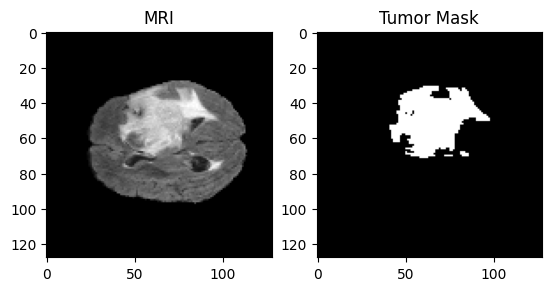

In [9]:
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title('MRI')
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title('Tumor Mask')
plt.show()

In [16]:
def unet_model(input_size=(128, 128, 1),
               base_filters=32,
               activation='relu',
               kernel_size=3):
    from tensorflow.keras.layers import Dropout

    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(base_filters, kernel_size, activation=activation, padding='same')(inputs)
    c1 = Conv2D(base_filters, kernel_size, activation=activation, padding='same')(c1)
    p1 = MaxPooling2D(2)(c1)

    c2 = Conv2D(base_filters*2, kernel_size, activation=activation, padding='same')(p1)
    c2 = Conv2D(base_filters*2, kernel_size, activation=activation, padding='same')(c2)
    p2 = MaxPooling2D(2)(c2)

    c3 = Conv2D(base_filters*4, kernel_size, activation=activation, padding='same')(p2)
    c3 = Conv2D(base_filters*4, kernel_size, activation=activation, padding='same')(c3)
    p3 = MaxPooling2D(2)(c3)

    # Bottleneck
    c4 = Conv2D(base_filters*8, kernel_size, activation=activation, padding='same')(p3)
    c4 = Conv2D(base_filters*8, kernel_size, activation=activation, padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(base_filters*4, 2, strides=2, padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(base_filters*4, kernel_size, activation=activation, padding='same')(u5)
    c5 = Conv2D(base_filters*4, kernel_size, activation=activation, padding='same')(c5)

    u6 = Conv2DTranspose(base_filters*2, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(base_filters*2, kernel_size, activation=activation, padding='same')(u6)
    c6 = Conv2D(base_filters*2, kernel_size, activation=activation, padding='same')(c6)

    u7 = Conv2DTranspose(base_filters, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(base_filters, kernel_size, activation=activation, padding='same')(u7)
    c7 = Conv2D(base_filters, kernel_size, activation=activation, padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    return Model(inputs, outputs)


In [17]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_19[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_21[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 32, 32,    │    131,200 │ conv2d_22[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,040 │ concatenate_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64,    │     32,832 │ conv2d_24[0][0] 

 Total params: 1,925,025 (7.34 MB)

 Trainable params: 1,925,025 (7.34 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import glob
import os

def load_dataset(num_cases=10):  # You can increase this later
    X, Y = [], []
    base_folder = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

    folders = sorted(glob.glob(base_folder + "/BraTS20_Training_*"))[:num_cases]

    for folder in folders:
        flair = os.path.join(folder, os.path.basename(folder) + "_flair.nii")
        seg = os.path.join(folder, os.path.basename(folder) + "_seg.nii")

        img, mask = preprocess_single_case(flair, seg)
        X.append(img)
        Y.append(mask)

    return np.array(X), np.array(Y)

X_train, Y_train = load_dataset(num_cases=300)  # You can increase for better training
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


X_train shape: (300, 128, 128, 1)
Y_train shape: (300, 128, 128, 1)



Training with LR=0.01, Batch Size=4
→ Train Acc: 0.9679, Val Acc: 0.9723, Test Acc: 0.9690

Training with LR=0.01, Batch Size=8
→ Train Acc: 0.9679, Val Acc: 0.9723, Test Acc: 0.9690

Training with LR=0.01, Batch Size=16
→ Train Acc: 0.9679, Val Acc: 0.9723, Test Acc: 0.9690

Training with LR=0.001, Batch Size=4
→ Train Acc: 0.9887, Val Acc: 0.9876, Test Acc: 0.9863

Training with LR=0.001, Batch Size=8
→ Train Acc: 0.9839, Val Acc: 0.9880, Test Acc: 0.9849

Training with LR=0.001, Batch Size=16
→ Train Acc: 0.9753, Val Acc: 0.9815, Test Acc: 0.9806

Training with LR=0.0001, Batch Size=4
→ Train Acc: 0.9880, Val Acc: 0.9897, Test Acc: 0.9873

Training with LR=0.0001, Batch Size=8
→ Train Acc: 0.9843, Val Acc: 0.9868, Test Acc: 0.9842

Training with LR=0.0001, Batch Size=16
→ Train Acc: 0.9808, Val Acc: 0.9825, Test Acc: 0.9807

=== Accuracy Results ===
       lr  batch_size  train_acc   val_acc  test_acc
0  0.0100           4   0.967893  0.972329  0.969026
1  0.0100           8   0.96

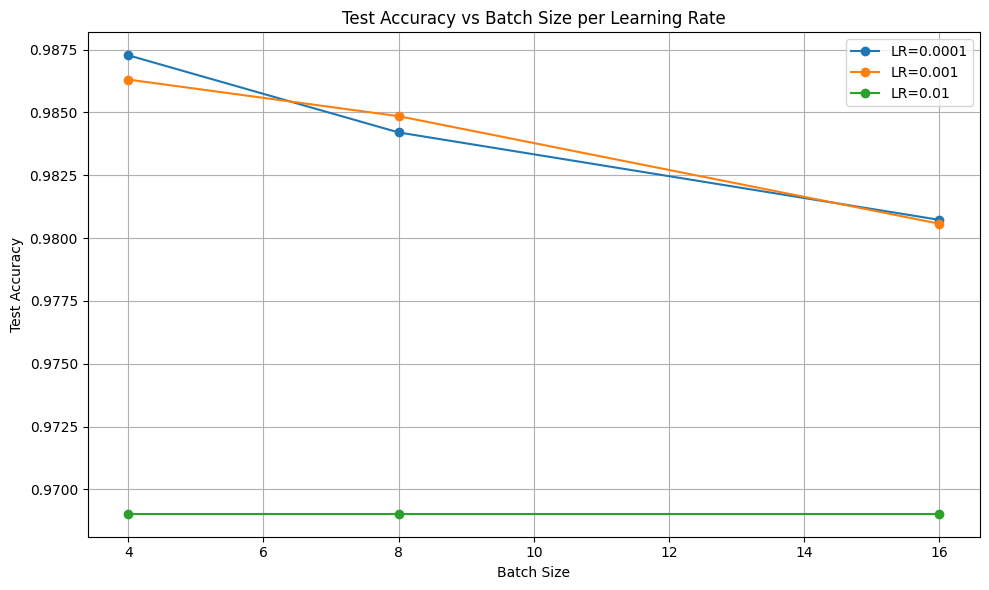

In [19]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Split dataset into train (60%), val (20%), test (20%)
X_temp, X_test, Y_temp, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Hyperparameters
learning_rates = [1e-2, 1e-3, 1e-4]
batch_sizes = [4, 8, 16]
epochs = 25

# Stores
results = []
all_histories = {}

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\nTraining with LR={lr}, Batch Size={bs}")
        tf.keras.backend.clear_session()

        model = unet_model()
        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            X_tr, Y_tr,
            epochs=epochs,
            batch_size=bs,
            validation_data=(X_val, Y_val),
            verbose=0
        )

        # Evaluate on test set
        test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]

        results.append({
            'lr': lr,
            'batch_size': bs,
            'train_acc': final_train_acc,
            'val_acc': final_val_acc,
            'test_acc': test_acc
        })

        key = f"LR={lr}, BS={bs}"
        all_histories[key] = history

        print(f"→ Train Acc: {final_train_acc:.4f}, Val Acc: {final_val_acc:.4f}, Test Acc: {test_acc:.4f}")

# Results as DataFrame
df = pd.DataFrame(results)
print("\n=== Accuracy Results ===")
print(df)

# Plot: Test Accuracy vs Batch Size
plt.figure(figsize=(10, 6))
for lr in sorted(df['lr'].unique()):
    subset = df[df['lr'] == lr]
    plt.plot(subset['batch_size'], subset['test_acc'], marker='o', label=f"LR={lr}")
plt.title("Test Accuracy vs Batch Size per Learning Rate")
plt.xlabel("Batch Size")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
history = model.fit(
    X_train, Y_train,
    epochs=25,
    batch_size=4,
    validation_split=0.2
)


Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9416 - loss: 0.3142 - val_accuracy: 0.9642 - val_loss: 0.1044
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9698 - loss: 0.0782 - val_accuracy: 0.9642 - val_loss: 0.0985
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9696 - loss: 0.0776 - val_accuracy: 0.9642 - val_loss: 0.1026
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9682 - loss: 0.0689 - val_accuracy: 0.9642 - val_loss: 0.0843
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9705 - loss: 0.0682 - val_accuracy: 0.9642 - val_loss: 0.0710
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9706 - loss: 0.0542 - val_accuracy: 0.9642 - val_loss: 0.0625
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9757 - loss: 0.0510 - val_accuracy: 0.9787 - val_loss: 0.0561
Epoch 8/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9833 - loss: 0.0459 - val_accuracy: 0.9815 -

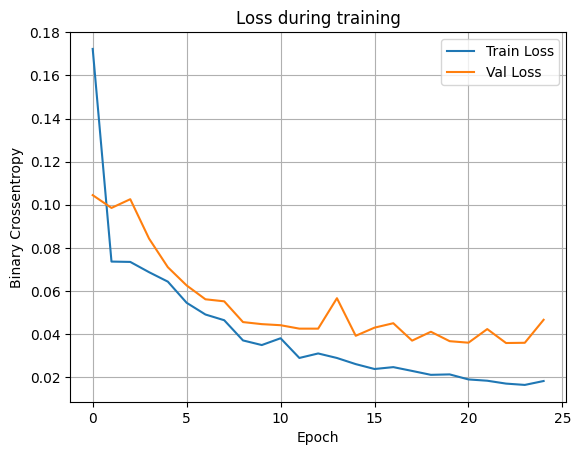

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


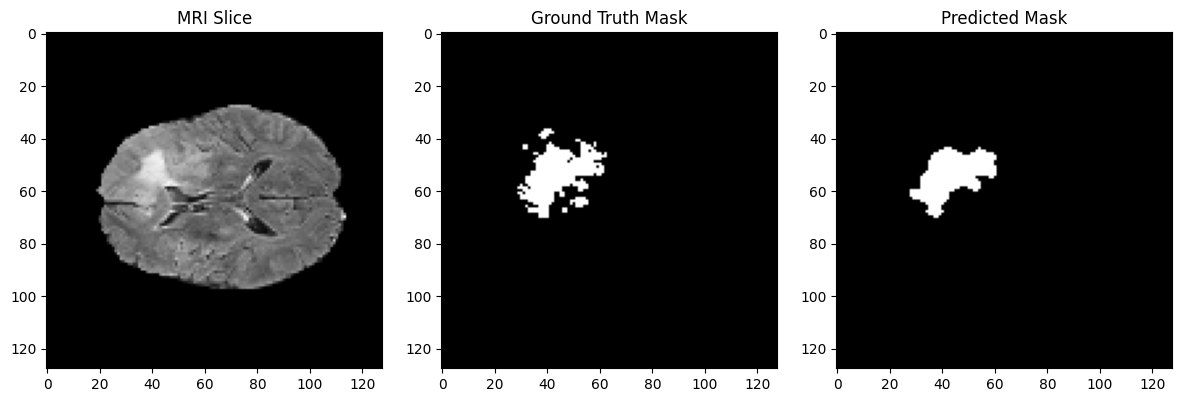

In [ ]:
# Pick a random test image (or reuse from earlier)
test_img, test_mask = preprocess_single_case(
    "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_030/BraTS20_Training_030_flair.nii",
    "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_030/BraTS20_Training_030_seg.nii"
)

# Add batch dimension
test_input = np.expand_dims(test_img, axis=0)

# Predict tumor mask
pred_mask = model.predict(test_input)[0]

# Threshold the prediction (since it's sigmoid output)
pred_mask = (pred_mask > 0.5).astype(np.float32)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_img.squeeze(), cmap='gray')
plt.title('MRI Slice')

plt.subplot(1, 3, 2)
plt.imshow(test_mask.squeeze(), cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title('Predicted Mask')

plt.tight_layout()
plt.show()


In [ ]:
!pip install pennylane --quiet


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


In [ ]:
from sklearn.preprocessing import LabelEncoder
import cv2

def prepare_quantum_data(X, Y, img_size=4):
    X_q, y_q = [], []

    for img, mask in zip(X, Y):
        label = 1 if np.sum(mask) > 0 else 0  # Tumor present or not

        # Resize to (img_size, img_size)
        resized = cv2.resize(img.squeeze(), (img_size, img_size))

        # Flatten the resized image (img_size x img_size -> img_size**2 features)
        X_q.append(resized.flatten())
        y_q.append(label)

    return np.array(X_q), np.array(y_q)

X_q, y_q = prepare_quantum_data(X_train, Y_train, img_size=2)  # Resize to 2x2 for 4 features
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_q, y_q, test_size=0.2, random_state=42)

print("Quantum input shape:", X_train_q.shape)



In [ ]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]


In [ ]:
class QuantumClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        weight_shapes = {"weights": (3, n_qubits)}  # 3 layers
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        self.fc = nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = self.q_layer(x)
        x = self.fc(x)
        return torch.sigmoid(x)


In [ ]:
model = QuantumClassifier()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model again
X_tensor = torch.tensor(X_train_q, dtype=torch.float32)
y_tensor = torch.tensor(y_train_q, dtype=torch.float32).view(-1, 1)

for epoch in range(20):
    optimizer.zero_grad()
    preds = model(X_tensor)
    loss = loss_fn(preds, y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")



In [ ]:
X_test_tensor = torch.tensor(X_test_q, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_q, dtype=torch.float32).view(-1, 1)

with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_preds = (test_preds > 0.5).float()
    accuracy = (test_preds == y_test_tensor).float().mean()
    print("Test Accuracy:", accuracy.item())


In [ ]:
# After training
torch.save(model.state_dict(), "brain_tumor_qcnn_model.pth")